In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("data/bank-full.csv", delimiter=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [3]:
cols = ["age", "job", "marital", "education", "balance", "housing", "contact",
        "day", "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]
df = df[cols]

In [4]:
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)
df.iloc[:, -1]

/tmp/ipykernel_27189/3763624093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)


0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
y_train = df_train['y']
y_val = df_val['y']
y_test = df_test['y']
df_train = df_train.drop('y', axis=1)
df_val = df_val.drop('y', axis=1)
df_test = df_test.drop('y', axis=1)

In [7]:
numerical_df = df.select_dtypes(include=['number'])
numerical_df

,age,balance,day,duration,campaign,pdays,previous,y
0,58,2143,5,261,1,-1,0,0
1,44,29,5,151,1,-1,0,0
2,33,2,5,76,1,-1,0,0
3,47,1506,5,92,1,-1,0,0
4,33,1,5,198,1,-1,0,0
...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,1
45207,71,1729,17,456,2,-1,0,1
45208,72,5715,17,1127,5,184,3,1
45209,57,668,17,508,4,-1,0,0


# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

AUC can go below 0.5 if the variable is negatively correlated with the target variable

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
roc_auc_score(y_train, df_train["day"])

0.474042117616092

In [10]:
roc_auc_score(y_train, -df_train["day"])

0.525957882383908

In [11]:
roc_auc_score(y_train, df_train['balance'])

0.5888313805382317

In [12]:
from functools import reduce
features = ['balance', 'day', 'duration', 'previous']

def anon1(d, item):
    s = roc_auc_score(y_train, df_train[item])
    if s >= 0.5:
        d[item] = s
    else:
        d[item] = roc_auc_score(y_train, -df_train[item])
    return d

res = reduce(anon1, features, {})
res      

{'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'previous': 0.5985653242764153}

In [13]:
max_key = max(res, key=res.get)
max_val = res[max_key]
max_key, max_val

('duration', 0.8147002759670778)

# Question 2: Training the model
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [15]:
def one_hot_encoding(df, dv, train=True):
    x_dict = df.to_dict(orient='records')
    if train:
        return dv.fit_transform(x_dict)
    else:
        return dv.transform(x_dict)

In [16]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [17]:
dv = DictVectorizer(sparse=False)
x_train = one_hot_encoding(df_train, dv)
model.fit(x_train, y_train)

x_val = one_hot_encoding(df_val, dv, train=False)
y_val_pred = model.predict(x_val)

roc_auc_score(y_val, y_val_pred)

0.6577696883650032

In [18]:
y_val_pred_proba = model.predict_proba(x_val)[:,1]
roc_auc_score(y_val, y_val_pred_proba)

0.9004060986101251

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.265
- 0.465
- 0.665
- 0.865

In [19]:
thresholds = np.linspace(0, 1, 101)

In [20]:
def anon2(acc, t):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_val_pred_proba >= t)
    predict_negative = (y_val_pred_proba < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    acc.append((t, tp, fp, fn, tn))
    return acc

scores = reduce(anon2, thresholds, [])

In [28]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [29]:
df_scores

,threshold,tp,fp,fn,tn,p,r
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,7003,4,941,0.135112,0.996357
2,0.02,1093,5788,5,2156,0.158843,0.995446
3,0.03,1087,4740,11,3204,0.186545,0.989982
4,0.04,1069,3799,29,4145,0.219597,0.973588
...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.638298,0.027322
97,0.97,25,15,1073,7929,0.625000,0.022769
98,0.98,21,10,1077,7934,0.677419,0.019126
99,0.99,11,5,1087,7939,0.687500,0.010018


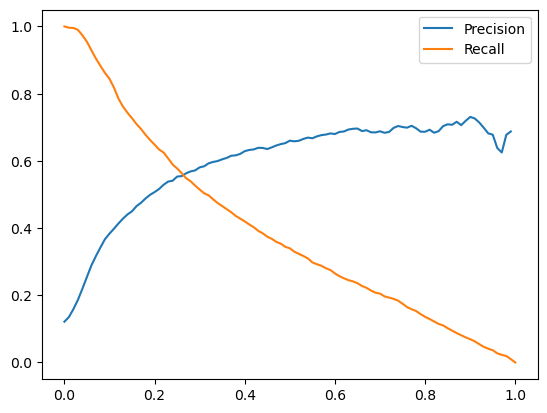

In [30]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

In [25]:
df_scores[df_scores.p == df_scores.r]

,threshold,tp,fp,fn,tn,p,r


In [32]:
intersection_indices = np.where(np.isclose(df_scores['p'], df_scores['r'], atol=1e-2))[0]
intersection_indices

array([26])

In [34]:
df_scores.iloc[26]

threshold       0.260000
tp            619.000000
fp            497.000000
fn            479.000000
tn           7447.000000
p               0.554659
r               0.563752
Name: 26, dtype: float64

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [36]:
df_scores['f1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

In [37]:
df_scores['f1'].idxmax()

22

In [38]:
df_scores.iloc[22]

threshold       0.220000
tp            686.000000
fp            611.000000
fn            412.000000
tn           7333.000000
p               0.528913
r               0.624772
f1              0.572860
Name: 22, dtype: float64

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26


In [41]:
from sklearn.model_selection import KFold

In [42]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [49]:
def train(df_train, y_train, C=1.0):
    cols_wo_y = cols[:-1]
    dicts = df_train[cols_wo_y].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [50]:
def predict(df, dv, model):
    cols_wo_y = cols[:-1]
    dicts = df[cols_wo_y].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [58]:
def get_5fold_mean_std(C=1.0):
    def anon3(acc, elm):
        train_idx, val_idx = elm
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        acc.append(auc)
        return acc
    
    scores = reduce(anon3, kfold.split(df_full_train), [])
    return np.mean(scores), np.std(scores)

In [59]:
mean, std = get_5fold_mean_std()

In [60]:
std

0.005496968608748504

In [61]:
mean

0.905951908446562

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [67]:
def anon4(acc, C):
    acc.append((C,) + get_5fold_mean_std(C))
    return acc

In [68]:
res = reduce(anon4, [0.000001, 0.001, 1], [])

In [69]:
res

[(1e-06, 0.7014445869766514, 0.009444095099939862),
 (0.001, 0.8610965910003857, 0.007059051468598092),
 (1, 0.905951908446562, 0.005496968608748504)]